## Reproducing figures from the project description

   MC Step   Ratio    Energy   Order
0        0  0.5000 -447.1427  0.2950
1        1  0.7175 -625.9669  0.3096
2        2  0.5950 -742.6330  0.3473
3        3  0.6700 -844.5010  0.3316
4        4  0.5550 -906.1256  0.3439
   nCalls  Total Time  Per Call (total)  Cumulative Time  \
0    1011         0.0               0.0            0.004   
1      34         0.0               0.0            0.000   
2       6         0.0               0.0            0.000   
3    1001         0.0               0.0            0.004   
4      14         0.0               0.0            0.000   

   Per Call (cumulative)                                           Function  
0                    0.0            <__array_function__ internals>:177(all)  
1                    0.0            <__array_function__ internals>:177(any)  
2                    0.0     <__array_function__ internals>:177(atleast_1d)  
3                    0.0     <__array_function__ internals>:177(atleast_2d)  
4                    0.0  <

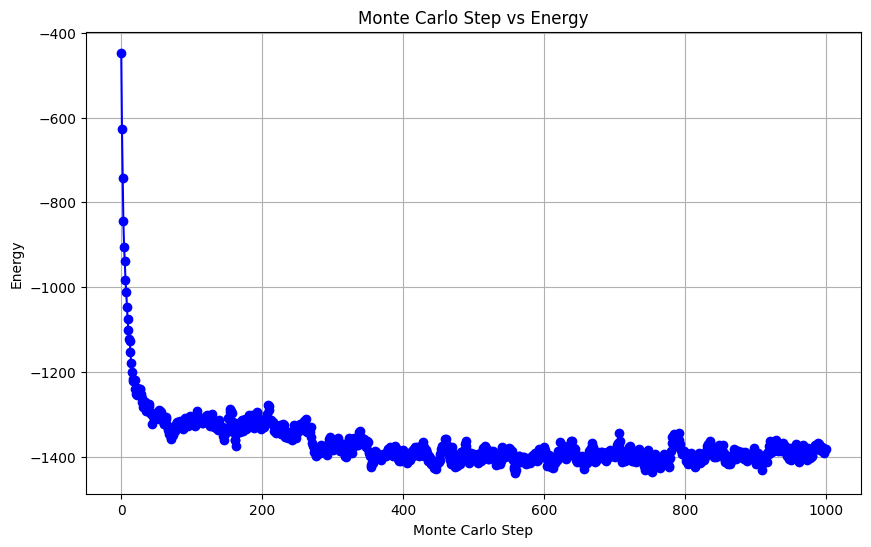

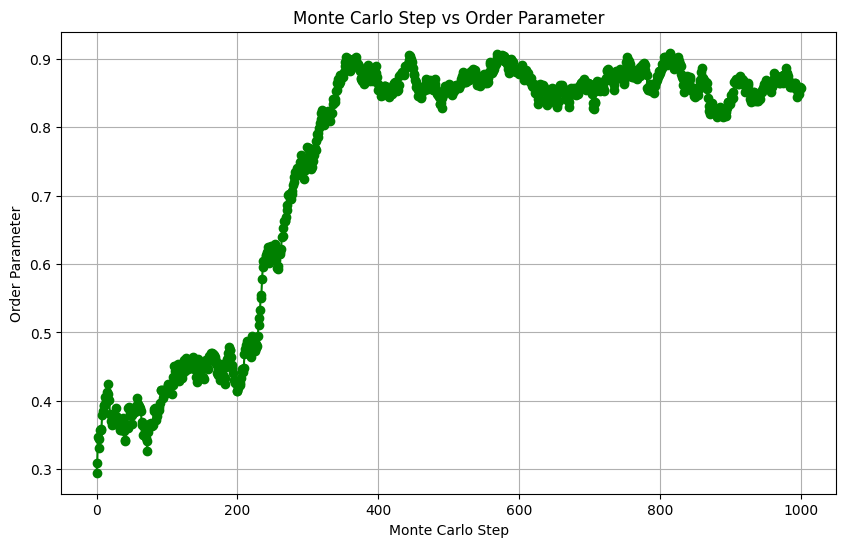

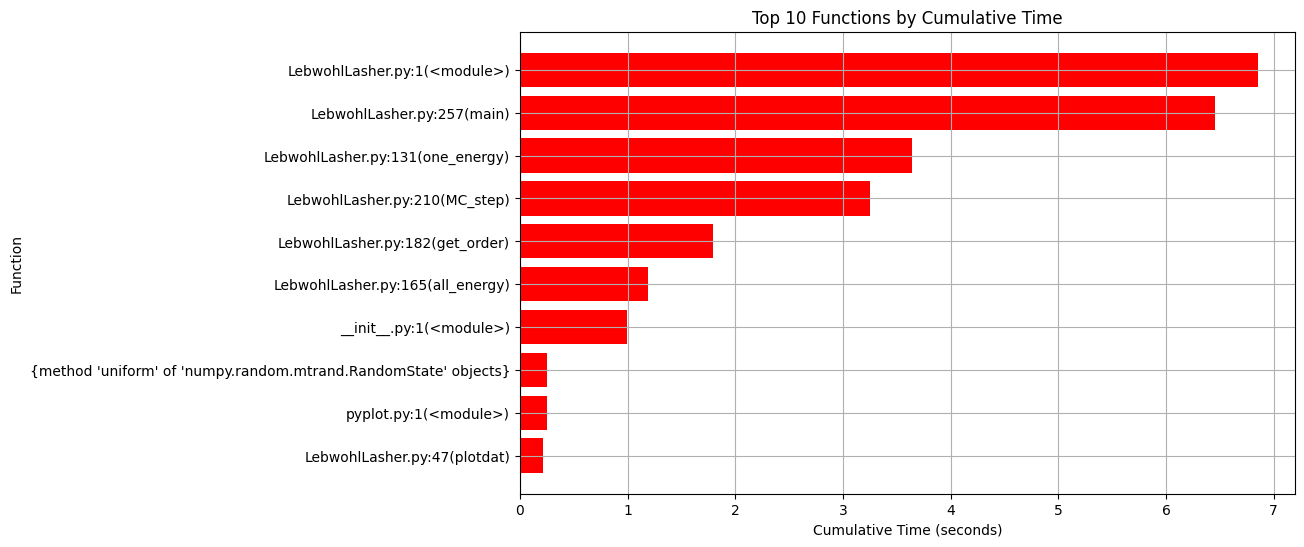

In [5]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import shutil

# Function to run LebwohlLasher.py multiple times and save outputs
def run_simulations(lattice_size, mc_steps, temperatures, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get the directory where LebwohlLasher.py exists
    lebwohl_dir = os.path.dirname(os.path.abspath('LebwohlLasher.py'))

    for temp in temperatures:
        # Define unique filenames for output files
        output_filename = f'LL-Output-lattice_{lattice_size}-steps_{mc_steps}-temp_{temp:.3f}.txt'
        profile_filename = f'prof-lattice_{lattice_size}-steps_{mc_steps}-temp_{temp:.3f}.txt'
        output_filepath = os.path.join(output_dir, output_filename)
        profile_filepath = os.path.join(output_dir, profile_filename)

        # Run the LebwohlLasher.py simulation with profiling
        command = f'python3.10 -m cProfile LebwohlLasher.py {mc_steps} {lattice_size} {temp} {mc_steps} > "{profile_filepath}"'
        subprocess.run(command, shell=True)

        # After running the command, move the LL-Output file to output_dir with the desired filename
        # Find the LL-Output file in the LebwohlLasher.py directory
        ll_output_files = [f for f in os.listdir(lebwohl_dir) if f.startswith('LL-Output') and f.endswith('.txt')]
        if ll_output_files:
            # Get the most recently modified LL-Output file
            latest_ll_output_file = max(
                [os.path.join(lebwohl_dir, f) for f in ll_output_files],
                key=os.path.getmtime
            )
            # Move and rename the LL-Output file to the output directory
            shutil.move(latest_ll_output_file, output_filepath)
        else:
            print(f"No LL-Output file found for temperature {temp}.")

# Parameters for simulations
lattice_size = 100
mc_steps = 50
temperatures = [0.5]
output_dir = 'simulation_results'

# Run simulations
run_simulations(lattice_size, mc_steps, temperatures, output_dir)

# Load and process LL output file
def load_ll_output(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        match = re.match(r'\s*(\d+)\s+(\d\.\d+)\s+([-\d\.]+)\s+(\d\.\d+)', line)
        if match:
            step, ratio, energy, order = match.groups()
            data.append([int(step), float(ratio), float(energy), float(order)])

    return pd.DataFrame(data, columns=['MC Step', 'Ratio', 'Energy', 'Order'])

# Load and process profile output file
def load_profile(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        match = re.match(r'\s*(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(.+)', line)
        if match:
            ncalls, tottime, percall1, cumtime, percall2, function = match.groups()
            data.append([int(ncalls), float(tottime), float(percall1), float(cumtime), float(percall2), function.strip()])

    return pd.DataFrame(data, columns=['nCalls', 'Total Time', 'Per Call (total)', 'Cumulative Time', 'Per Call (cumulative)', 'Function'])

# Filepaths for analysis
ll_output_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith('LL-Output')]
profile_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith('prof')]

# Load data from one of the simulations (as an example)
example_output_filepath = ll_output_files[0]
example_profile_filepath = profile_files[0]

ll_output_df = load_ll_output(example_output_filepath)
profile_df = load_profile(example_profile_filepath)
print(ll_output_df.head())
print(profile_df.head())
# Plot MC Step vs Energy
plt.figure(figsize=(10, 6))
plt.plot(ll_output_df['MC Step'], ll_output_df['Energy'], marker='o', linestyle='-', color='b')
plt.xlabel('Monte Carlo Step')
plt.ylabel('Energy')
plt.title('Monte Carlo Step vs Energy')
plt.grid(True)
plt.show()

# Plot MC Step vs Order Parameter
plt.figure(figsize=(10, 6))
plt.plot(ll_output_df['MC Step'], ll_output_df['Order'], marker='o', linestyle='-', color='g')
plt.xlabel('Monte Carlo Step')
plt.ylabel('Order Parameter')
plt.title('Monte Carlo Step vs Order Parameter')
plt.grid(True)
plt.show()

# Profile Data Analysis - Top 10 functions by cumulative time
profile_top10 = profile_df.sort_values(by='Cumulative Time', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(profile_top10['Function'], profile_top10['Cumulative Time'], color='r')
plt.xlabel('Cumulative Time (seconds)')
plt.ylabel('Function')
plt.title('Top 10 Functions by Cumulative Time')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()




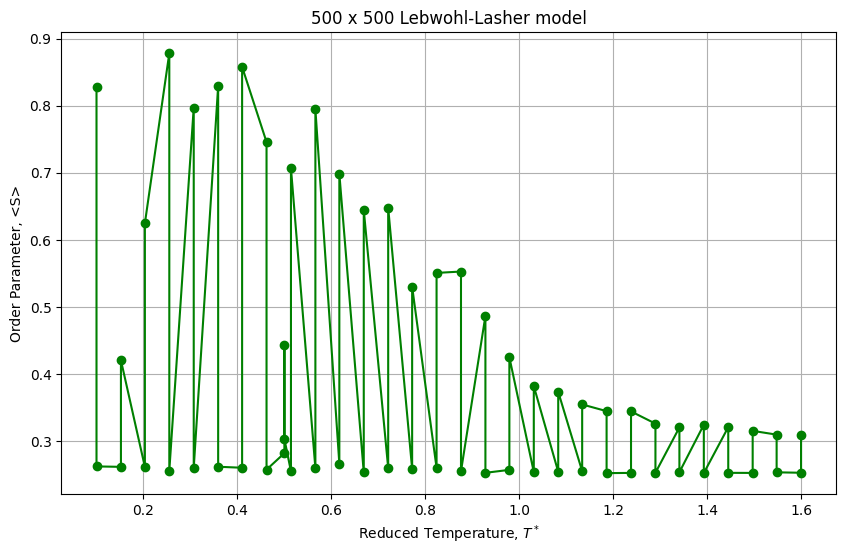

In [6]:
# Parameters for simulations
lattice_size = 500
mc_steps = 100
temperatures = np.linspace(0.1, 1.6, 30)  # Temperature range to match the plot you provided
output_dir = 'simulation_results'

# Run simulations across the temperature range
run_simulations(lattice_size, mc_steps, temperatures, output_dir)

# Gather all LL output files
ll_output_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith('LL-Output')]

# Loop over files, average the order parameter, and store results
temperature_order_params = []

for filepath in ll_output_files:
    temp_match = re.search(r'temp_(\d+\.\d+)', filepath)
    if temp_match:
        temp = float(temp_match.group(1))
        ll_output_df = load_ll_output(filepath)
        avg_order_param = ll_output_df['Order'].mean()  # Average over MC steps
        temperature_order_params.append((temp, avg_order_param))

# Convert to a DataFrame for plotting
temperature_order_df = pd.DataFrame(temperature_order_params, columns=['Temperature', 'Order Parameter'])

# Sort by temperature for a smooth plot
temperature_order_df.sort_values('Temperature', inplace=True)

# Plot the Order Parameter vs Reduced Temperature
plt.figure(figsize=(10, 6))
plt.errorbar(temperature_order_df['Temperature'], temperature_order_df['Order Parameter'], fmt='o-', color='green')
plt.xlabel('Reduced Temperature, $T^*$')
plt.ylabel('Order Parameter, <S>')
plt.title(f'{lattice_size} x {lattice_size} Lebwohl-Lasher model')
plt.grid(True)
plt.show()
